# Dataton
## Bike Sharing Scheme

**Objetivo**: Predecir la cantidad de bicicletas que se alquilan

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.preprocessing import PolynomialFeatures
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectPercentile, SelectKBest
from sklearn.decomposition import PCA
from scipy.stats import loguniform

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.simplefilter('ignore', DataConversionWarning)


### Importando Train

In [2]:
train = pd.read_excel('bike_train.xlsx')
train.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Importando Test

In [3]:
test = pd.read_excel('bike_test.xlsx')
test.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,12000,2012-05-20,2,1,5,4,0,0,0,1,0.52,0.5000,0.68,0.0896
1,12001,2012-05-20,2,1,5,5,0,0,0,1,0.50,0.4848,0.72,0.1045
2,12002,2012-05-20,2,1,5,6,0,0,0,1,0.50,0.4848,0.63,0.1343
3,12003,2012-05-20,2,1,5,7,0,0,0,1,0.52,0.5000,0.68,0.1940
4,12004,2012-05-20,2,1,5,8,0,0,0,1,0.56,0.5303,0.56,0.1642


### Desripción de las columnas

De acuerdo con el diccionario de datos, las columnas aportan la siguiente información

| Columna | Descripción |
|:-------:|:-------------:|
|instant|Identificador del registro|
|dteday|Fecha del registro|
|season|Temporada <br> 1: primavera <br> 2: verano <br> 3: otoño <br> 4: invierno|
|yr|Año del registro|
|mnth|Mes del registro|
|holiday|Si el día meteorológico es feriado toma el valor de 1, día normal toma el valor 0|
|weekday|Dia de la semana|
|workday|Si el día es laboral toma el valor de 1, en caso contrario 0|
|weathersit|Indica el tipo de clima que hubo en el momento del registro, las opciones son:<br>1: Despejado, algunas nubes o parcialmente nublado<br>2: Neblina con nubes, neblina con nubes fragmentadas, neblina con algunas nubes o sólo neblina<br>3: Nieve ligera, llovizna con tormenta eléctrica y nubes dispersas o llovizna con nubes dispersas<br>4: Lluvia con granizos, tormenta eléctrica y neblina, o nieve con niebla|
|temp|Temperatura normalizada en gradus Celsius. La escala llega hasta un máximo de 50°C|
|hum|Nivel de humedad normalizada. La escala llega a un máximo de 100|
|windspeed|Velocidad del viento normalizada. La escala llega a un máximo de 67 km/h|
|casual|Cantidad de usuarios casuales en el registro, siendo aquellos que no están registrados|
|registered|Cantidad de usuarios registrados en el registro|
|cnt|Cantidad total de bicicletas rentadas en el registro, incluyendo ambos tipos de usuarios (casuales y registrados)|

In [4]:
train.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000
mean,6000.000000,2.210684,0.279523,5.530294,11.556630,0.027752,3.009334,0.684057,1.435036,0.465704,0.448888,0.625770,0.196433,30.049837,128.545129,158.594966
std,3463.957275,1.088798,0.448784,3.433005,6.911891,0.164269,2.005264,0.464910,0.650894,0.188576,0.169633,0.200637,0.125394,43.596915,124.692750,151.392952
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3000.500000,1.000000,0.000000,3.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.320000,0.303000,0.470000,0.104500,3.000000,29.000000,34.000000
50%,6000.000000,2.000000,0.000000,5.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.460000,0.454500,0.620000,0.194000,13.000000,98.000000,118.000000
75%,8999.500000,3.000000,1.000000,8.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.620000,0.590900,0.790000,0.283600,39.000000,185.000000,232.000000
max,11999.000000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,0.960000,1.000000,1.000000,0.850700,367.000000,770.000000,957.000000


In [5]:
test.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
count,5380.000000,5380.000000,5380.0,5380.000000,5380.000000,5380.000000,5380.000000,5380.00000,5380.000000,5380.000000,5380.000000,5380.000000,5380.000000
mean,14689.500000,3.150558,1.0,8.784758,11.524721,0.031041,2.991078,0.67974,1.403532,0.566758,0.535741,0.630483,0.175968
std,1553.216555,0.839184,0.0,2.145166,6.920601,0.173444,2.007032,0.46662,0.612343,0.182800,0.161300,0.174493,0.113988
min,12000.000000,1.000000,1.0,5.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.140000,0.151500,0.160000,0.000000
25%,13344.750000,3.000000,1.0,7.000000,6.000000,0.000000,1.000000,0.00000,1.000000,0.400000,0.409100,0.490000,0.104500
50%,14689.500000,3.000000,1.0,9.000000,12.000000,0.000000,3.000000,1.00000,1.000000,0.600000,0.575800,0.640000,0.164200
75%,16034.250000,4.000000,1.0,11.000000,18.000000,0.000000,5.000000,1.00000,2.000000,0.700000,0.666700,0.780000,0.253700
max,17379.000000,4.000000,1.0,12.000000,23.000000,1.000000,6.000000,1.00000,3.000000,1.000000,0.924200,1.000000,0.656700


### Exploración de datos

Text(0, -0.02, 'La linea roja muestra el promedio de las observaciones')

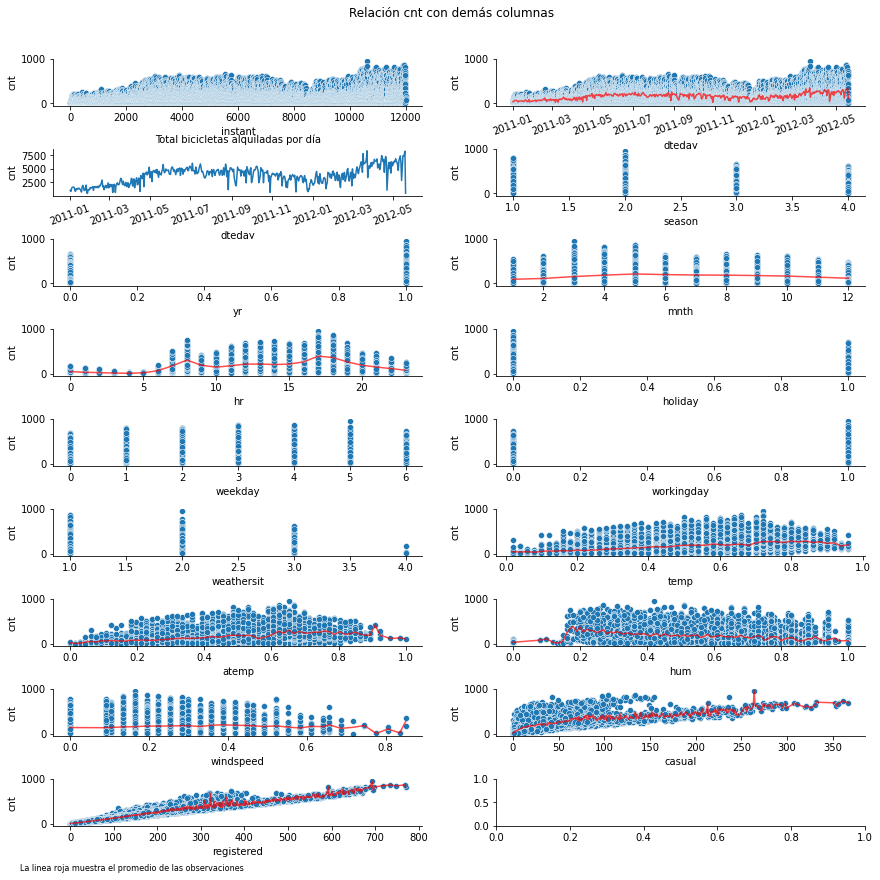

In [6]:
fig, ax = plt.subplots(9, 2, figsize=(12,12))
fig.tight_layout()
fig.subplots_adjust(top=0.92)
ax = ax.flatten()
i = 0
x = train.columns.drop(['cnt'])

for column in x:
    sns.scatterplot(ax=ax[i], x=column, y='cnt', data=train)
    ax[i].set_xlabel(column)
    ax[i].set_ylabel('cnt')

    if i == 1:
        sns.lineplot(ax=ax[i], x=column, y='cnt', data=train, estimator='mean', ci=None, color='red', alpha=0.7)

    if column == 'dteday':
        ax[i].tick_params('x', labelrotation=20)
        i += 1
        sns.lineplot(ax=ax[i], x=column, y='cnt', data=train, estimator='sum', ci=None)
        ax[i].tick_params('x', labelrotation=20)
        ax[i].set_title('Total bicicletas alquiladas por día', fontsize=10)
    
    if column != 'instant' and column != 'season' and column != 'yr' and column != 'holiday' and column != 'weekday' and\
         column != 'workingday' and column != 'weathersit' and i != 2:
         sns.lineplot(ax=ax[i], x=column, y='cnt', data=train, estimator='mean', ci=None, color='red', alpha=0.7)

    i += 1

plt.suptitle('Relación cnt con demás columnas', fontsize=12)
plt.subplots_adjust(hspace=0.92, wspace=0.2)
sns.despine(left=False, bottom=False)
fig.text(
    0, -0.02, 'La linea roja muestra el promedio de las observaciones', color="black", 
    fontsize=8
)

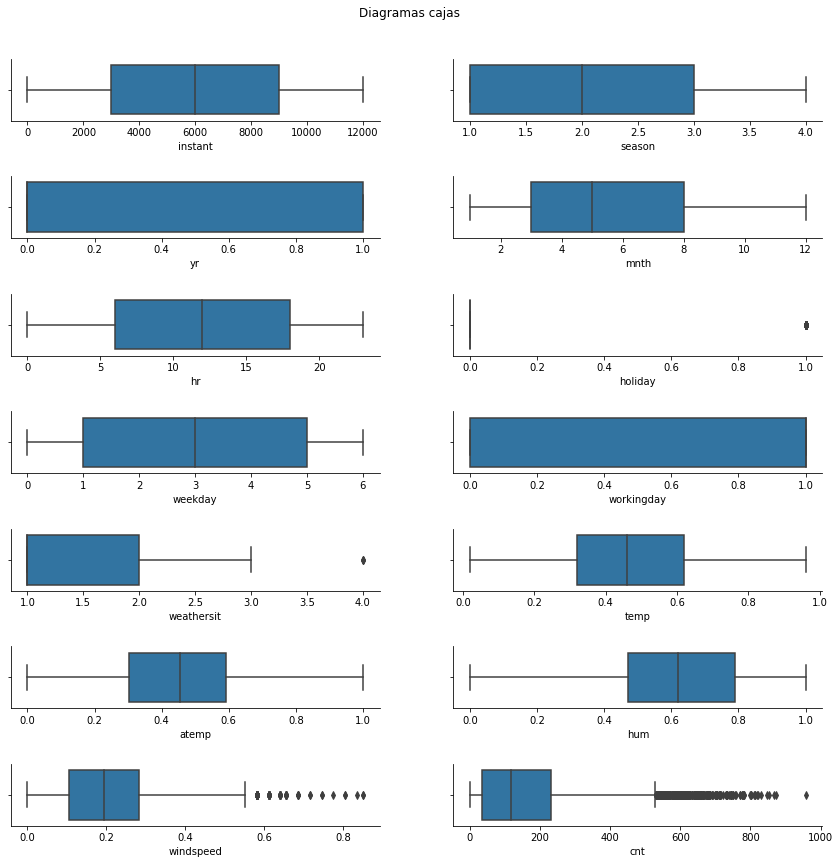

In [7]:
fig, ax = plt.subplots(7, 2, figsize=(12,12))
fig.tight_layout()
fig.subplots_adjust(top=0.92)
ax = ax.flatten()
i = 0
x = train.columns.drop(['dteday', 'casual', 'registered'])

for column in x:
    sns.boxplot(ax=ax[i], x=train[column])
    i += 1

plt.suptitle('Diagramas cajas', fontsize=12)
plt.subplots_adjust(hspace=0.9, wspace=0.2)
sns.despine(left=False, bottom=False)

Text(0.5, 1.0, 'Histograma - Windspeed')

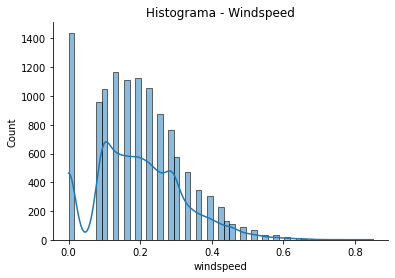

In [8]:
sns.histplot(x='windspeed', data=train, kde=True)
sns.despine(left=False, bottom=False)
plt.title('Histograma - Windspeed')

Al realizar el pairplot se encuentra dificil observar la información debido al número de columnas. Sin embargo, se encuentran patrones interesantes especialmente cuando se grafican la relación entre las variables climáticas. Pero la relación que más nos interesa es la relación entre nuestra variable objetivo y las demás columnas. Así pues se graficaron dichas relaciones, con excepción de aquellas que no aportan información alguna.

Se observa en los datos un incremento en el alquiler de bicicletas a lo largo de los años visibles en el dataset, aunque se observa un leve decrecimiento durante el invierno de 2011-2012. Lo cual es lógico ya que no demasiadas personas suelen montar bicicleta durante dicha temporada. Al graficar el alquiler diario de bicicletas durante las diferentes temporadas, se observa que durante el invierno suele disminuir aunque los valores se encuentran muy cercanos a los valores de alquiler en otoño. Donde si se llega a ver una diferencia es en la grafica mensual y en la gráfica de temperatura. En ellas se puede observar como el total de alquier disminuye durante los meses de enero y diciembre y cuando las temperaturas suelen ser bajas. Al hablar de temperaturas también se puede observar que a temperaturas ambientales y sensación térmica, los alquileres también disminuyen. Esto debido a que realizar actividad física durante temporadas de temperaturas altas puede implicar efectos adversos a la salud. De igual manera, la cantidad de bicicletas alquiladas disminuye considerablemente cuando hay condiciones climáticas adversas, tales como lluvias, nevadas y vientos fuertes.

También se puede observar que la columna de año no muestra demasiada información ya que la diferencia entre sus valores es poca y lo que se puede obtener de esta columna es que de un año a otro han incrementado el número de bicicletas alquiladas. Por su lado holiday y working day si bien también tienen diferencias pequeñas deben continuar en el dataset ya que estas columnas muestran diferencias en los números de bicicletas alquiladas en los días no laborales y feriados.

Al realizar un diagrama de cajas se ven datos por fuera de los rangos intercuartiles en windspeed y cnt. En el caso de windspeed, claramente hay una desviación de los datos hacia la derecha de acuerdo con la gráfica. Sin embargo, al buscar información historica sobre la velocidad del viento en Washington DC., se encuentra que en promedio la velocidad del viento en dicha ciudad es de 9 mph (14 km/h) por lo que en mi opinión no se debería volver a reescalar. En el caso de cnt, que es el total de bicicletas alquiladas por hora, puede existir momentos donde la capacidad total del servicio es usada o multiples bicicletas son usadas en cortos trayectos dentro de la hora, así que el problema realmente es no tener dicha información para poder calcular y verificar aquellos eventos que realmente sean outliers.

Lo que si es necesario realizar es crear variables dummy para las columnas season y weather, ya que al tener un rango de valores, los valores altos pueden sesgar el modelo.

### Selección de Features

Text(0.5, 1.0, 'Correlación de variables')

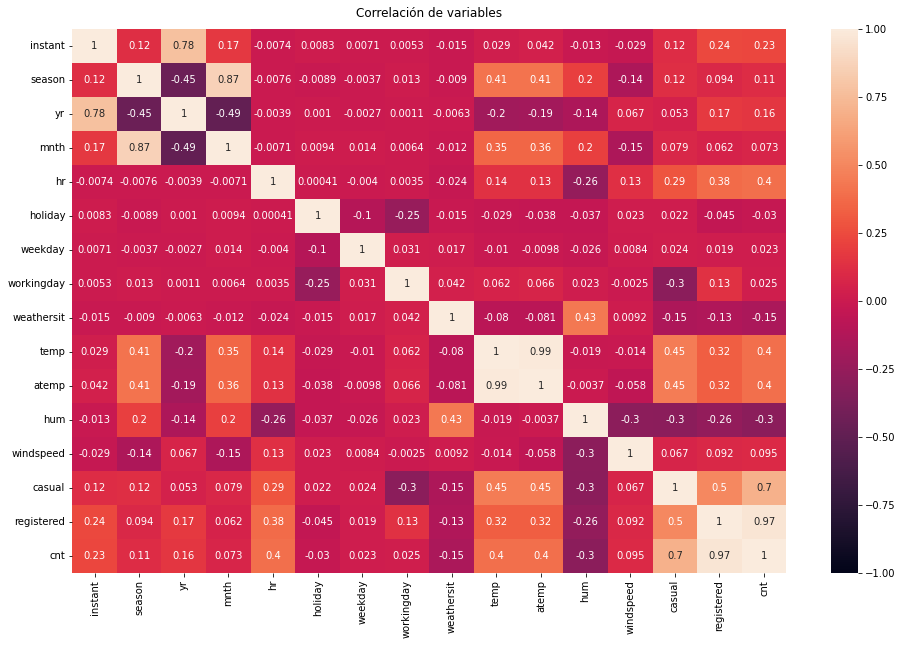

In [9]:
plt.figure(figsize=(16,10))
heatmap = sns.heatmap(train.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlación de variables', fontdict={'fontsize':12}, pad=12)

In [10]:
season = pd.get_dummies(train['season'], prefix='season')
train = pd.concat([train, season], axis = 1)
train.drop(['season'], axis=1, inplace=True)
season = pd.get_dummies(train['weathersit'], prefix='weathersit')
train = pd.concat([train, season], axis = 1)
train.drop(['weathersit'], axis=1, inplace=True)
train['weathersit_4'] = 0 #get_dummies no lo transforma pero es necesario ponerlo para no perder información
train.head()

,instant,dteday,yr,mnth,hr,holiday,weekday,workingday,temp,atemp,...,registered,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,1,2011-01-01,0,1,0,0,6,0,0.24,0.2879,...,13,16,1,0,0,0,1,0,0,0
1,2,2011-01-01,0,1,1,0,6,0,0.22,0.2727,...,32,40,1,0,0,0,1,0,0,0
2,3,2011-01-01,0,1,2,0,6,0,0.22,0.2727,...,27,32,1,0,0,0,1,0,0,0
3,4,2011-01-01,0,1,3,0,6,0,0.24,0.2879,...,10,13,1,0,0,0,1,0,0,0
4,5,2011-01-01,0,1,4,0,6,0,0.24,0.2879,...,1,1,1,0,0,0,1,0,0,0


In [11]:
season = pd.get_dummies(test['season'], prefix='season')
test = pd.concat([test, season], axis = 1)
test.drop(['season'], axis=1, inplace=True)
season = pd.get_dummies(test['weathersit'], prefix='weathersit')
test = pd.concat([test, season], axis = 1)
test.drop(['weathersit'], axis=1, inplace=True)
test['weathersit_4'] = 0 #get_dummies no lo transforma pero es necesario ponerlo para no perder información
test.head()

,instant,dteday,yr,mnth,hr,holiday,weekday,workingday,temp,atemp,hum,windspeed,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,12000,2012-05-20,1,5,4,0,0,0,0.52,0.5000,0.68,0.0896,0,1,0,0,1,0,0,0
1,12001,2012-05-20,1,5,5,0,0,0,0.50,0.4848,0.72,0.1045,0,1,0,0,1,0,0,0
2,12002,2012-05-20,1,5,6,0,0,0,0.50,0.4848,0.63,0.1343,0,1,0,0,1,0,0,0
3,12003,2012-05-20,1,5,7,0,0,0,0.52,0.5000,0.68,0.1940,0,1,0,0,1,0,0,0
4,12004,2012-05-20,1,5,8,0,0,0,0.56,0.5303,0.56,0.1642,0,1,0,0,1,0,0,0


De acuerdo al mapa de calor no hay correlaciones fuertes entre las columnas y la variable objetivo. Las columnas con mayor correlación son hr, temp y atemp. Exluyo casual y registered ya que son columnas que forman la variable objetivo y no se iban a tener en cuenta para realizar la predicción. Ahora bien si miramos la correlación entre temp y atemp, encontramos que ambas tienen una correlación fuerte entre ellas ya que una mide la temperatura ambiente y la otra la sensación térmica, por lo que se puede excluir a una de ellas. Instant tiene una correlación fuerte con yr, pero al ser una columna que identifica el registro tampoco se tiene en cuenta. Mientras que season y month se debe debatir sobre su uso. Season categoriza los meses de acuerdo a las temporadas climáticas, por lo que month representaría mejor los datos. Así pues las columnas a usar son:

|Columnas|
|:------:|
|instant|
|mnth|
|hr|
|holiday|
|weekday|
|workingday|
|weathersit (1-4)|
|temp|
|hum|
|windspeed|
|season (1-4)|

Para predecir la variable objetivo se aplicará GradientBoostingRegressor y AdaBoostRegresor y se seleccionará el mejor

In [70]:
X = train[['instant', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit_1',
            'weathersit_2', 'weathersit_3', 'weathersit_4', 'temp', 'hum', 'windspeed',
           'season_1', 'season_2', 'season_3', 'season_4']]

y = train[['cnt']]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## GradientBoostingRegressor

### Modelo inicial

In [13]:
gb_model = GradientBoostingRegressor(random_state=42)

gb_model.fit(x_train, y_train)
train_pred = gb_model.predict(x_train)
train_error = mean_squared_error(y_train, train_pred, squared=False)
print('Train Error: ', train_error)
test_pred = gb_model.predict(x_test)
test_error = mean_squared_error(y_test, test_pred, squared=False)
print('Test Error: ', test_error)

Train Error:  53.65180067025856
Test Error:  54.332748154569664


El modelo tiene un minusculo overfit, el cual se puede reducir mediante la reducción de features y la optimización de hiperparametros

### Selección de features

#### Con SelectPercentile

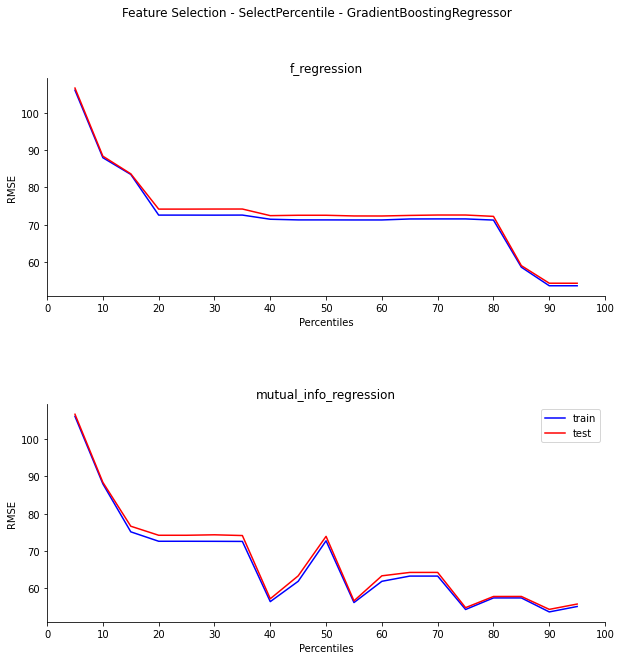

In [14]:
np.random.seed(42)
functions = [f_regression, mutual_info_regression]
percentiles = [i for i in range(5, 100, 5)]
train_error = []
test_error = []

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax.flatten()

for function in functions:
    for percentile in percentiles:
        selector = SelectPercentile(function, percentile=percentile)
        selector.fit(x_train, y_train)
        x_train_trans = selector.transform(x_train)
        x_test_trans = selector.transform(x_test)

        gb_model.fit(x_train_trans, y_train)

        train_pred = gb_model.predict(x_train_trans)
        train_rmse = mean_squared_error(y_train, train_pred, squared=False)
        train_error.append(train_rmse)

        test_pred = gb_model.predict(x_test_trans)
        test_rmse = mean_squared_error(y_test, test_pred, squared=False)
        test_error.append(test_rmse)

    if function == functions[0]:
        sns.lineplot(ax=ax[0], x=percentiles, y=train_error, color='blue')
        sns.lineplot(ax=ax[0], x=percentiles, y=test_error, color='red')
        ax[0].set_xlabel('Percentiles')
        ax[0].set_ylabel('RMSE')
        ax[0].set_title('f_regression')
        ax[0].set_xticks([i for i in range(0, 110, 10)])
    elif function == functions[1]:
        sns.lineplot(ax=ax[1], x=percentiles, y=train_error, color='blue')
        sns.lineplot(ax=ax[1], x=percentiles, y=test_error, color='red')
        ax[1].set_xlabel('Percentiles')
        ax[1].set_ylabel('RMSE')
        ax[1].set_title('mutual_info_regression')
        ax[1].set_xticks([i for i in range(0, 110, 10)])

    train_error.clear()
    test_error.clear()

plt.suptitle('Feature Selection - SelectPercentile - GradientBoostingRegressor')
sns.despine(left=False, bottom=False)
plt.subplots_adjust(hspace=0.5)
plt.legend(['train', 'test'])

In [15]:
np.random.seed(42)
functions = [f_regression, mutual_info_regression]

for function in functions:
    selector = SelectPercentile(function, percentile=90)
    selector.fit(x_train, y_train)
    x_train_trans = selector.transform(x_train)
    x_test_trans = selector.transform(x_test)

    gb_model.fit(x_train_trans, y_train)

    train_pred = gb_model.predict(x_train_trans)
    train_rmse = mean_squared_error(y_train, train_pred, squared=False)
    print(f'Resultados para {function}')
    print('Train error: ', train_rmse)

    test_pred = gb_model.predict(x_test_trans)
    test_rmse = mean_squared_error(y_test, test_pred, squared=False)
    print('Test error: ', test_rmse)
    print('-'*20)

Resultados para <function f_regression at 0x0000024A0D17CC10>
Train error:  53.65180067025855
Test error:  54.33274815456965
--------------------
Resultados para <function mutual_info_regression at 0x0000024A0D699790>
Train error:  56.5757227607173
Test error:  57.05156148783522
--------------------


In [16]:
np.random.seed(42)
selector = SelectPercentile(mutual_info_regression, percentile=75)
selector.fit(x_train, y_train)
x_train_trans = selector.transform(x_train)
x_test_trans = selector.transform(x_test)

gb_model.fit(x_train_trans, y_train)

train_pred = gb_model.predict(x_train_trans)
train_rmse = mean_squared_error(y_train, train_pred, squared=False)
print(f'Resultados para {mutual_info_regression} y percentile = 75')
print('Train error: ', train_rmse)

test_pred = gb_model.predict(x_test_trans)
test_rmse = mean_squared_error(y_test, test_pred, squared=False)
print('Test error: ', test_rmse)

Resultados para <function mutual_info_regression at 0x0000024A0D699790> y percentile = 75
Train error:  55.85997401610701
Test error:  56.71244021945313


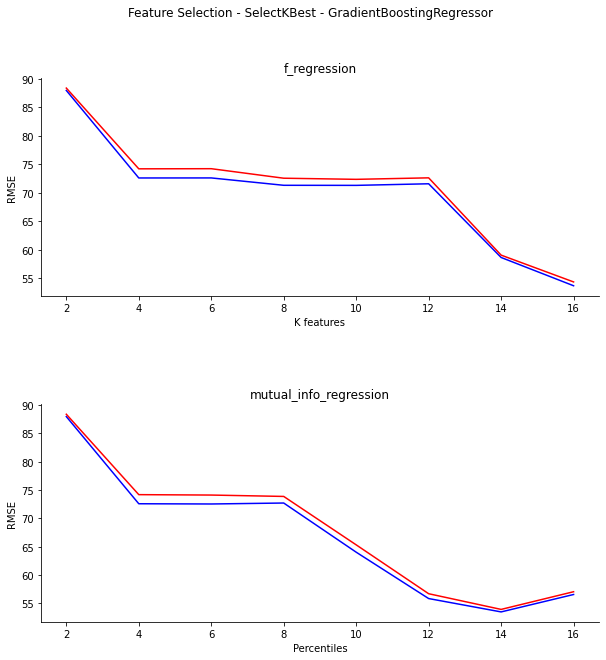

In [17]:
functions = [f_regression, mutual_info_regression]
features = [i for i in range(2, 18, 2)]
train_error = []
test_error = []

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax.flatten()

for function in functions:
    for feature in features:
        np.random.seed(42)
        selector = SelectKBest(function, k=feature)
        selector.fit(x_train, y_train)
        x_train_trans = selector.transform(x_train)
        x_test_trans = selector.transform(x_test)

        gb_model.fit(x_train_trans, y_train)

        train_pred = gb_model.predict(x_train_trans)
        train_rmse = mean_squared_error(y_train, train_pred, squared=False)
        train_error.append(train_rmse)

        test_pred = gb_model.predict(x_test_trans)
        test_rmse = mean_squared_error(y_test, test_pred, squared=False)
        test_error.append(test_rmse)

    if function == functions[0]:
        sns.lineplot(ax=ax[0], x=features, y=train_error, color='blue')
        sns.lineplot(ax=ax[0], x=features, y=test_error, color='red')
        ax[0].set_xlabel('K features')
        ax[0].set_ylabel('RMSE')
        ax[0].set_title('f_regression')
    elif function == functions[1]:
        sns.lineplot(ax=ax[1], x=features, y=train_error, color='blue')
        sns.lineplot(ax=ax[1], x=features, y=test_error, color='red')
        ax[1].set_xlabel('Percentiles')
        ax[1].set_ylabel('RMSE')
        ax[1].set_title('mutual_info_regression')
    train_error.clear()
    test_error.clear()

plt.suptitle('Feature Selection - SelectKBest - GradientBoostingRegressor')
sns.despine(left=False, bottom=False)
plt.subplots_adjust(hspace=0.5)

In [22]:
np.random.seed(42)
selector = SelectKBest(f_regression, k=16)
selector.fit(x_train, y_train)
x_train_trans = selector.transform(x_train)
x_test_trans = selector.transform(x_test)

gb_model.fit(x_train_trans, y_train)

train_pred = gb_model.predict(x_train_trans)
train_rmse = mean_squared_error(y_train, train_pred, squared=False)

test_pred = gb_model.predict(x_test_trans)
test_rmse = mean_squared_error(y_test, test_pred, squared=False)
print('Resultado para f_regression:')
print('Train error: ', train_rmse)
print('Test error: ', test_rmse)
print('-'*30)

np.random.seed(42)
selector = SelectKBest(mutual_info_regression, k=14)
selector.fit(x_train, y_train)
x_train_trans = selector.transform(x_train)
x_test_trans = selector.transform(x_test)

gb_model.fit(x_train_trans, y_train)

train_pred = gb_model.predict(x_train_trans)
train_rmse = mean_squared_error(y_train, train_pred, squared=False)

test_pred = gb_model.predict(x_test_trans)
test_rmse = mean_squared_error(y_test, test_pred, squared=False)
print('Resultado para mutual_info_regression:')
print('Train error: ', train_rmse)
print('Test error: ', test_rmse)

Resultado para f_regression:
Train error:  53.65180067025856
Test error:  54.32244387982159
------------------------------
Resultado para mutual_info_regression:
Train error:  53.50447450449644
Test error:  53.946980590922735


In [26]:
np.random.seed(42)
selector = SelectKBest(mutual_info_regression, k=14)
selector.fit(x_train, y_train)
x_train_trans = selector.transform(x_train)
x_test_trans = selector.transform(x_test)

gb_model.fit(x_train_trans, y_train)

train_pred = gb_model.predict(x_train_trans)
train_rmse = mean_squared_error(y_train, train_pred, squared=False)

test_pred = gb_model.predict(x_test_trans)
test_rmse = mean_squared_error(y_test, test_pred, squared=False)
print('Resultado para mutual_info_regression:')
print('Train error: ', train_rmse)
print('Test error: ', test_rmse)
print(selector.get_feature_names_out(x_train.columns))

Resultado para mutual_info_regression:
Train error:  53.50447450449644
Test error:  53.946980590922735
['instant' 'mnth' 'hr' 'holiday' 'weekday' 'workingday' 'weathersit_3'
 'temp' 'hum' 'windspeed' 'season_1' 'season_2' 'season_3' 'season_4']


(135.602, 135.604)

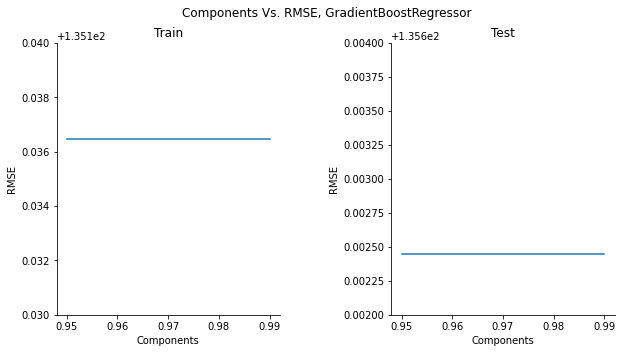

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax.flatten()

components = [0.95, 0.96, 0.97, 0.98, 0.99]
train_error = []
test_error = []

for value in components:
  pca = PCA(n_components=value)
  pca.fit(x_train)
  train_features = pca.transform(x_train)
  
  gb_model.fit(train_features, y_train)
  train_pred = gb_model.predict(train_features)
  train_rmse = mean_squared_error(y_train, train_pred, squared=False)
  train_error.append(train_rmse)

  test_features = pca.transform(x_test)
  test_pred = gb_model.predict(test_features)
  test_rmse = mean_squared_error(y_test, test_pred, squared=False)
  test_error.append(test_rmse)

sns.lineplot(ax=ax[0], x=components, y=train_error)
ax[0].set_xlabel('Components')
ax[0].set_ylabel('RMSE')
ax[0].set_title('Train')
sns.lineplot(ax=ax[1], x=components, y=test_error)
ax[1].set_xlabel('Components')
ax[1].set_ylabel('RMSE')
ax[1].set_title('Test')
sns.despine(left=False, bottom=False)
title_text = 'Components Vs. RMSE, GradientBoostRegressor'
plt.suptitle(title_text)
plt.subplots_adjust(wspace=0.5)
ax[0].set_ylim([135.13, 135.14])
ax[1].set_ylim([135.602, 135.604])

Luego de realizar las evaluaciones de los métodos de selección de features encontramos que PCA no presenta un cambio importante en el resultado, tanto así que no se puede ver incluso al realizar zoom en el gráfico. En el caso de SelectKBest si bien se presenta una mejoría al usar la función mutual_info_regression y 12 features, lo mismo ocurre en SelectPercentile usando 75%, aunque en dicho caso el error en el set de training aumenta. Tomando 14 features y mutual_info_regression, da un valor de 53.5044 para train y 53.9469 para test por lo que se selecciona este método y función para seleccionar las features. Hay que aclarar que para poder volver a tener dicho resultado después de cada prueba se hizo necesario crear una semilla usando np.random.seed().

### Optimización de hiperparametros

In [41]:
param_distributions = {
    "n_estimators": [i for i in range(500, 1000, 100)],
    "max_leaf_nodes": [2, 5, 10, 20, 50, 100],
    "learning_rate": loguniform(0.01, 1),
}
search_cv = RandomizedSearchCV(gb_model, param_distributions=param_distributions,
    scoring="neg_root_mean_squared_error", n_iter=20, cv=10, random_state=42, verbose=10
)
search_cv.fit(x_train_trans, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV 1/10; 1/20] START learning_rate=0.05611516415334504, max_leaf_nodes=50, n_estimators=700
[CV 1/10; 1/20] END learning_rate=0.05611516415334504, max_leaf_nodes=50, n_estimators=700;, score=-43.635 total time=  15.1s
[CV 2/10; 1/20] START learning_rate=0.05611516415334504, max_leaf_nodes=50, n_estimators=700
[CV 2/10; 1/20] END learning_rate=0.05611516415334504, max_leaf_nodes=50, n_estimators=700;, score=-46.437 total time=  15.2s
[CV 3/10; 1/20] START learning_rate=0.05611516415334504, max_leaf_nodes=50, n_estimators=700
[CV 3/10; 1/20] END learning_rate=0.05611516415334504, max_leaf_nodes=50, n_estimators=700;, score=-41.911 total time=  12.7s
[CV 4/10; 1/20] START learning_rate=0.05611516415334504, max_leaf_nodes=50, n_estimators=700
[CV 4/10; 1/20] END learning_rate=0.05611516415334504, max_leaf_nodes=50, n_estimators=700;, score=-40.343 total time=  11.8s
[CV 5/10; 1/20] START learning_rate=0.05611516415334504, max_

RandomizedSearchCV(cv=10,
                   estimator=GradientBoostingRegressor(learning_rate=0.058200133727098494,
                                                       max_leaf_nodes=20,
                                                       n_estimators=500,
                                                       random_state=42),
                   n_iter=20,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000024A168FEA90>,
                                        'max_leaf_nodes': [2, 5, 10, 20, 50,
                                                           100],
                                        'n_estimators': [500, 600, 700, 800,
                                                         900]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=10)

In [42]:
print(search_cv.best_params_)
print(search_cv.best_score_)

{'learning_rate': 0.36256176345762264, 'max_leaf_nodes': 50, 'n_estimators': 600}
-37.26807923090147


In [71]:
np.random.seed(42)
selector = SelectKBest(mutual_info_regression, k=14)
selector.fit(x_train, y_train)
x_train_trans = selector.transform(x_train)
x_test_trans = selector.transform(x_test)
params = search_cv.best_params_

gb_model = GradientBoostingRegressor(random_state=42, **params)
gb_model.fit(x_train_trans, y_train)

train_pred = gb_model.predict(x_train_trans)
train_rmse = mean_squared_error(y_train, train_pred, squared=False)

test_pred = gb_model.predict(x_test_trans)
test_rmse = mean_squared_error(y_test, test_pred, squared=False)
print('Train error: ', train_rmse)
print('Test error: ', test_rmse)

Train error:  23.222648166389423
Test error:  36.933274547785


<AxesSubplot:xlabel='instant', ylabel='cnt'>

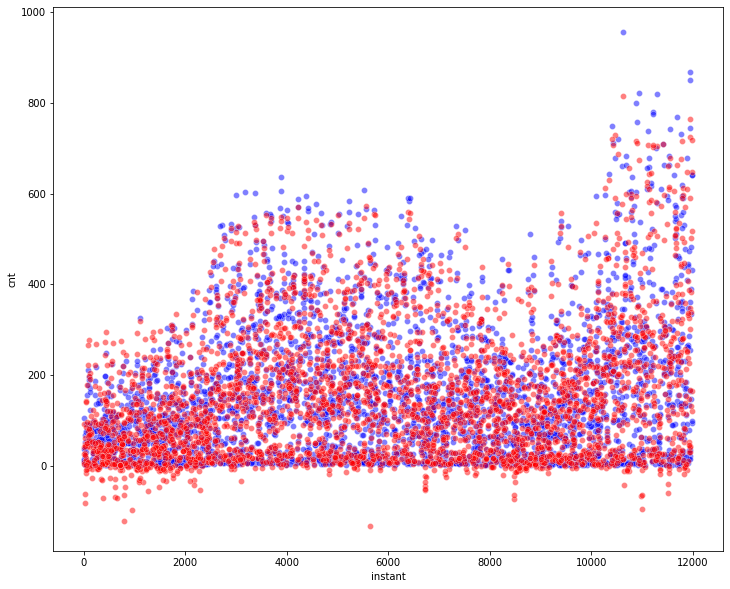

In [72]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=x_test['instant'], y=y_test['cnt'], color='blue', alpha=0.5)
sns.scatterplot(x=x_test['instant'], y=test_pred, color='red', alpha=0.5)

In [75]:
X_test = test[['instant', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit_1',
            'weathersit_2', 'weathersit_3', 'weathersit_4', 'temp', 'hum', 'windspeed',
           'season_1', 'season_2', 'season_3', 'season_4']]

test_df_trans = selector.transform(X_test)
test_df_pred = gb_model.predict(test_df_trans)

test_df_pred = np.round(test_df_pred)
test_df_pred[test_df_pred < 0] = 00
test_df_pred = np.abs(test_df_pred)

df = pd.DataFrame(test_df_pred, columns=['pred'])
df.head()

,pred
0,0.0
1,0.0
2,12.0
3,76.0
4,285.0


In [76]:
df.describe()

,pred
count,5380.000000
mean,291.279740
std,228.755049
min,0.000000
25%,93.000000
50%,265.000000
75%,452.000000
max,978.000000


In [78]:
df.to_csv('Malegiraldo22.csv', index=False, encoding='utf-8')